In [ ]:
# In this notebook

In [1]:
# Import necessary dependencies
# We are using yahoo_fin module, it is essentially a Python scraper that extracts finance data from Yahoo Finance platform

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from yahoo_fin import stock_info as si
from collections import deque

import os
import numpy as np
import pandas as pd
import random

In [6]:
# set seed, so we can get the same results after rerunning several times
np.random.seed(314)
tf.random.set_seed(314)
random.seed(314)

# Data Preprocessing

# First, we need to write a function that downloads the dataset from the Internet and preprocess it:

## This function is long but handy, it accepts several arguments to be as flexible as possible:

- The ticker argument is the ticker we want to load, for instance, you can use TSLA for Tesla stock market, AAPL for Apple and so on. It can also be a pandas Dataframe with the condition it includes the columns in feature_columns as well as date as index.
- n_steps integer indicates the historical sequence length we want to use, some people call it the window size, recall that we are going to use a recurrent neural network, we need to feed in to the network a sequence data, choosing 50 means that we will use 50 days of stock prices to predict the next lookup time step.
- scale is a boolean variable that indicates whether to scale prices from 0 to 1, we will set this to True as scaling high values from 0 to 1 will help the neural network to learn much faster and more effectively.
- okup_step is the future lookup step to predict, the default is set to 1 (e.g next day). 15 means the next 15 days, and so on.
- split_by_date is a boolean which indicates whether we split our training and testing sets by date, setting it to False means we randomly split the data into training and testing using sklearn's train_test_split() function. If it's True (the default), we split the data in date order.

### We will be using all the features available in this dataset, which are the open, high, low, volume and adjusted close. Please check this tutorial to learn more what these indicators are.

### The above function does the following:
- First, it loads the dataset using stock_info.get_data() function in yahoo_fin module.
- It adds the "date" column from the index if it doesn't exist, this will help us later to get the features of the testing set.
- If the scale argument is passed as True, it will scale all the prices from 0 to 1 (including the volume) using the sklearn's MinMaxScaler class. Note that each column has its own scaler.
- It then adds the future column which indicates the target values (the labels to predict, or the y's) by shifting the adjusted close column by lookup_step.
- After that, it shuffles and splits the data to training and testing sets, and finally returns the result.

### To understand the code even better, I highly suggest you to manually print the output variable (result) and see how the features and labels are made.

In [7]:
def shuffle_in_unison(a, b):
    # shuffle two arrays in the same way
    state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(state)
    np.random.shuffle(b)

def load_data(ticker, n_steps=50, scale=True, shuffle=True, lookup_step=1, split_by_date=True,
                test_size=0.2, feature_columns=['adjclose', 'volume', 'open', 'high', 'low']):
    """
    Loads data from Yahoo Finance source, as well as scaling, shuffling, normalizing and splitting.
    Params:
        ticker (str/pd.DataFrame): the ticker you want to load, examples include AAPL, TESL, etc.
        n_steps (int): the historical sequence length (i.e window size) used to predict, default is 50
        scale (bool): whether to scale prices from 0 to 1, default is True
        shuffle (bool): whether to shuffle the dataset (both training & testing), default is True
        lookup_step (int): the future lookup step to predict, default is 1 (e.g next day)
        split_by_date (bool): whether we split the dataset into training/testing by date, setting it 
            to False will split datasets in a random way
        test_size (float): ratio for test data, default is 0.2 (20% testing data)
        feature_columns (list): the list of features to use to feed into the model, default is everything grabbed from yahoo_fin
    """
    # see if ticker is already a loaded stock from yahoo finance
    if isinstance(ticker, str):
        # load it from yahoo_fin library
        df = si.get_data(ticker)
    elif isinstance(ticker, pd.DataFrame):
        # already loaded, use it directly
        df = ticker
    else:
        raise TypeError("ticker can be either a str or a `pd.DataFrame` instances")
    # this will contain all the elements we want to return from this function
    result = {}
    # we will also return the original dataframe itself
    result['df'] = df.copy()
    # make sure that the passed feature_columns exist in the dataframe
    for col in feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."
    # add date as a column
    if "date" not in df.columns:
        df["date"] = df.index
    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler
        # add the MinMaxScaler instances to the result returned
        result["column_scaler"] = column_scaler
    # add the target column (label) by shifting by `lookup_step`
    df['future'] = df['adjclose'].shift(-lookup_step)
    # last `lookup_step` columns contains NaN in future column
    # get them before droping NaNs
    last_sequence = np.array(df[feature_columns].tail(lookup_step))
    # drop NaNs
    df.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=n_steps)
    for entry, target in zip(df[feature_columns + ["date"]].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])
    # get the last sequence by appending the last `n_step` sequence with `lookup_step` sequence
    # for instance, if n_steps=50 and lookup_step=10, last_sequence should be of 60 (that is 50+10) length
    # this last_sequence will be used to predict future stock prices that are not available in the dataset
    last_sequence = list([s[:len(feature_columns)] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)
    # add to result
    result['last_sequence'] = last_sequence
    # construct the X's and y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)
    # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    if split_by_date:
        # split the dataset into training & testing sets by date (not randomly splitting)
        train_samples = int((1 - test_size) * len(X))
        result["X_train"] = X[:train_samples]
        result["y_train"] = y[:train_samples]
        result["X_test"]  = X[train_samples:]
        result["y_test"]  = y[train_samples:]
        if shuffle:
            # shuffle the datasets for training (if shuffle parameter is set)
            shuffle_in_unison(result["X_train"], result["y_train"])
            shuffle_in_unison(result["X_test"], result["y_test"])
    else:    
        # split the dataset randomly
        result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, 
                                                                                test_size=test_size, shuffle=shuffle)
    # get the list of test set dates
    dates = result["X_test"][:, -1, -1]
    # retrieve test features from the original dataframe
    result["test_df"] = result["df"].loc[dates]
    # remove duplicated dates in the testing dataframe
    result["test_df"] = result["test_df"][~result["test_df"].index.duplicated(keep='first')]
    # remove dates from the training/testing sets & convert to float32
    result["X_train"] = result["X_train"][:, :, :len(feature_columns)].astype(np.float32)
    result["X_test"] = result["X_test"][:, :, :len(feature_columns)].astype(np.float32)
    return result

# Create the Model

In [8]:
def create_model(sequence_length, n_features, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), batch_input_shape=(None, sequence_length, n_features)))
            else:
                model.add(cell(units, return_sequences=True, batch_input_shape=(None, sequence_length, n_features)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model

# Training the Model

## So the below code is all about defining all the hyper parameters we gonna use, we explained some of them, while we didn't on the others:

- TEST_SIZE: The testing set rate. For instance 0.2 means 20% of the total dataset.
- FEATURE_COLUMNS: The features we gonna use to predict the next price value.
- N_LAYERS: Number of RNN layers to use.
- CELL: RNN cell to use, default is LSTM.
- UNITS: Number of cell units.
- DROPOUT: The dropout rate is the probability of not training a given node in a layer, where 0.0 means no dropout at all. This type of regularization can help the model to not overfit on our training data.
- BIDIRECTIONAL: Whether to use bidirectional recurrent neural networks.
- LOSS: Loss function to use for this regression problem, we're using Huber loss, you can use mean absolute error (mae) or mean squared error (mse) as well.
- OPTIMIZER: Optimization algorithm to use, defaulting to Adam.
- BATCH_SIZE: The number of data samples to use on each training iteration.
- EPOCHS: The number of times that the learning algorithm will pass through the entire training dataset, we used 500 here, but try to increase it further more.

In [9]:
import os
import time
from tensorflow.keras.layers import LSTM

# Window size or the sequence length
N_STEPS = 50

# Lookup step, 1 is the next day
LOOKUP_STEP = 15

# whether to scale feature columns & output price as well
SCALE = True
scale_str = f"sc-{int(SCALE)}"

# whether to shuffle the dataset
SHUFFLE = True
shuffle_str = f"sh-{int(SHUFFLE)}"

# whether to split the training/testing set by date
SPLIT_BY_DATE = False
split_by_date_str = f"sbd-{int(SPLIT_BY_DATE)}"

# test ratio size, 0.2 is 20%
TEST_SIZE = 0.2

# features to use
FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low"]

# date now
date_now = time.strftime("%Y-%m-%d")

### model parameters
N_LAYERS = 2

# LSTM cell
CELL = LSTM

# 256 LSTM neurons
UNITS = 256

# 40% dropout
DROPOUT = 0.4

# whether to use bidirectional RNNs
BIDIRECTIONAL = False

### training parameters
# mean absolute error loss
# LOSS = "mae"
# huber loss
LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 64
EPOCHS = 500

# Amazon stock market
ticker = "AMZN"
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")

# model name to save, making it as unique as possible based on parameters
model_name = f"{date_now}_{ticker}-{shuffle_str}-{scale_str}-{split_by_date_str}-\
{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"
if BIDIRECTIONAL:
    model_name += "-b"

In [ ]:
# Make folders for the 'results', 'logs', and 'data' before training begins

In [10]:
# create these folders if they does not exist
if not os.path.isdir("results"):
    os.mkdir("results")
if not os.path.isdir("logs"):
    os.mkdir("logs")
if not os.path.isdir("data"):
    os.mkdir("data")

In [ ]:
# Now, make function calls to implement the model

In [11]:
# load the data
data = load_data(ticker, N_STEPS, scale=SCALE, split_by_date=SPLIT_BY_DATE, 
                shuffle=SHUFFLE, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, 
                feature_columns=FEATURE_COLUMNS)

# save the dataframe
data["df"].to_csv(ticker_data_filename)

# construct the model
model = create_model(N_STEPS, len(FEATURE_COLUMNS), loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)

# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))

# train the model and save the weights whenever we see 
# a new optimal model using ModelCheckpoint
history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)

Epoch 1/500
75/75 [==============================] - 27s 332ms/step - loss: 0.0039 - mean_absolute_error: 0.0378 - val_loss: 1.3144e-04 - val_mean_absolute_error: 0.0082

Epoch 00001: val_loss improved from inf to 0.00013, saving model to results\2021-04-16_AMZN-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-15-layers-2-units-256.h5
Epoch 2/500
75/75 [==============================] - 23s 300ms/step - loss: 4.1157e-04 - mean_absolute_error: 0.0136 - val_loss: 2.6275e-04 - val_mean_absolute_error: 0.0129

Epoch 00002: val_loss did not improve from 0.00013
Epoch 3/500
75/75 [==============================] - 23s 305ms/step - loss: 5.4804e-04 - mean_absolute_error: 0.0160 - val_loss: 1.8139e-04 - val_mean_absolute_error: 0.0130

Epoch 00003: val_loss did not improve from 0.00013
Epoch 4/500
75/75 [==============================] - 29s 388ms/step - loss: 3.7801e-04 - mean_absolute_error: 0.0138 - val_loss: 1.2379e-04 - val_mean_absolute_error: 0.0073

Epoch 00004: val_loss improved from 


Epoch 00069: val_loss did not improve from 0.00011
Epoch 70/500
75/75 [==============================] - 32s 428ms/step - loss: 2.9292e-04 - mean_absolute_error: 0.0136 - val_loss: 1.3096e-04 - val_mean_absolute_error: 0.0086

Epoch 00070: val_loss did not improve from 0.00011
Epoch 71/500
75/75 [==============================] - 32s 433ms/step - loss: 2.3892e-04 - mean_absolute_error: 0.0127 - val_loss: 1.5108e-04 - val_mean_absolute_error: 0.0085

Epoch 00071: val_loss did not improve from 0.00011
Epoch 72/500
75/75 [==============================] - 33s 445ms/step - loss: 2.5290e-04 - mean_absolute_error: 0.0131 - val_loss: 1.0126e-04 - val_mean_absolute_error: 0.0067

Epoch 00072: val_loss improved from 0.00011 to 0.00010, saving model to results\2021-04-16_AMZN-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-15-layers-2-units-256.h5
Epoch 73/500
75/75 [==============================] - 32s 433ms/step - loss: 2.4390e-04 - mean_absolute_error: 0.0127 - val_loss: 1.3658e-04 - val_m

75/75 [==============================] - 25s 335ms/step - loss: 2.4522e-04 - mean_absolute_error: 0.0125 - val_loss: 8.8825e-05 - val_mean_absolute_error: 0.0061

Epoch 00138: val_loss improved from 0.00009 to 0.00009, saving model to results\2021-04-16_AMZN-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-15-layers-2-units-256.h5
Epoch 139/500
75/75 [==============================] - 4720s 64s/step - loss: 1.9522e-04 - mean_absolute_error: 0.0116 - val_loss: 1.3523e-04 - val_mean_absolute_error: 0.0089

Epoch 00139: val_loss did not improve from 0.00009
Epoch 140/500
75/75 [==============================] - 22s 296ms/step - loss: 2.3145e-04 - mean_absolute_error: 0.0122 - val_loss: 1.0248e-04 - val_mean_absolute_error: 0.0069

Epoch 00140: val_loss did not improve from 0.00009
Epoch 141/500
75/75 [==============================] - 22s 299ms/step - loss: 2.1563e-04 - mean_absolute_error: 0.0119 - val_loss: 1.0289e-04 - val_mean_absolute_error: 0.0078

Epoch 00141: val_loss did not impr

75/75 [==============================] - 29s 384ms/step - loss: 2.1828e-04 - mean_absolute_error: 0.0119 - val_loss: 9.8295e-05 - val_mean_absolute_error: 0.0076

Epoch 00209: val_loss did not improve from 0.00009
Epoch 210/500
75/75 [==============================] - 29s 384ms/step - loss: 1.8243e-04 - mean_absolute_error: 0.0112 - val_loss: 9.1509e-05 - val_mean_absolute_error: 0.0067

Epoch 00210: val_loss did not improve from 0.00009
Epoch 211/500
75/75 [==============================] - 29s 387ms/step - loss: 2.3706e-04 - mean_absolute_error: 0.0125 - val_loss: 9.7867e-05 - val_mean_absolute_error: 0.0062

Epoch 00211: val_loss did not improve from 0.00009
Epoch 212/500
75/75 [==============================] - 29s 384ms/step - loss: 2.0938e-04 - mean_absolute_error: 0.0113 - val_loss: 9.5231e-05 - val_mean_absolute_error: 0.0065

Epoch 00212: val_loss did not improve from 0.00009
Epoch 213/500
75/75 [==============================] - 29s 386ms/step - loss: 2.1128e-04 - mean_absolu

75/75 [==============================] - 25s 332ms/step - loss: 1.8080e-04 - mean_absolute_error: 0.0110 - val_loss: 1.2105e-04 - val_mean_absolute_error: 0.0077

Epoch 00245: val_loss did not improve from 0.00009
Epoch 246/500
75/75 [==============================] - 25s 333ms/step - loss: 1.9900e-04 - mean_absolute_error: 0.0113 - val_loss: 9.2814e-05 - val_mean_absolute_error: 0.0063

Epoch 00246: val_loss did not improve from 0.00009
Epoch 247/500
75/75 [==============================] - 25s 334ms/step - loss: 1.9628e-04 - mean_absolute_error: 0.0115 - val_loss: 9.5849e-05 - val_mean_absolute_error: 0.0063

Epoch 00247: val_loss did not improve from 0.00009
Epoch 248/500
75/75 [==============================] - 25s 333ms/step - loss: 1.9436e-04 - mean_absolute_error: 0.0113 - val_loss: 9.1779e-05 - val_mean_absolute_error: 0.0067

Epoch 00248: val_loss did not improve from 0.00009
Epoch 249/500
75/75 [==============================] - 25s 332ms/step - loss: 1.8862e-04 - mean_absolu

75/75 [==============================] - 35s 471ms/step - loss: 1.8206e-04 - mean_absolute_error: 0.0113 - val_loss: 8.9737e-05 - val_mean_absolute_error: 0.0063

Epoch 00281: val_loss did not improve from 0.00009
Epoch 282/500
75/75 [==============================] - 34s 458ms/step - loss: 2.1138e-04 - mean_absolute_error: 0.0116 - val_loss: 1.0765e-04 - val_mean_absolute_error: 0.0075

Epoch 00282: val_loss did not improve from 0.00009
Epoch 283/500
75/75 [==============================] - 34s 458ms/step - loss: 1.7871e-04 - mean_absolute_error: 0.0110 - val_loss: 1.1889e-04 - val_mean_absolute_error: 0.0068

Epoch 00283: val_loss did not improve from 0.00009
Epoch 284/500
75/75 [==============================] - 25s 331ms/step - loss: 2.2179e-04 - mean_absolute_error: 0.0120 - val_loss: 9.7128e-05 - val_mean_absolute_error: 0.0064

Epoch 00284: val_loss did not improve from 0.00009
Epoch 285/500
75/75 [==============================] - 22s 287ms/step - loss: 2.2813e-04 - mean_absolu

75/75 [==============================] - 30s 401ms/step - loss: 1.8612e-04 - mean_absolute_error: 0.0113 - val_loss: 1.1100e-04 - val_mean_absolute_error: 0.0066

Epoch 00316: val_loss did not improve from 0.00009
Epoch 317/500
75/75 [==============================] - 35s 473ms/step - loss: 2.1213e-04 - mean_absolute_error: 0.0117 - val_loss: 1.2245e-04 - val_mean_absolute_error: 0.0073

Epoch 00317: val_loss did not improve from 0.00009
Epoch 318/500
75/75 [==============================] - 32s 426ms/step - loss: 2.3679e-04 - mean_absolute_error: 0.0123 - val_loss: 1.0029e-04 - val_mean_absolute_error: 0.0069

Epoch 00318: val_loss did not improve from 0.00009
Epoch 319/500
75/75 [==============================] - 29s 382ms/step - loss: 1.9602e-04 - mean_absolute_error: 0.0114 - val_loss: 1.3851e-04 - val_mean_absolute_error: 0.0092

Epoch 00319: val_loss did not improve from 0.00009
Epoch 320/500
75/75 [==============================] - 28s 377ms/step - loss: 2.0446e-04 - mean_absolu

75/75 [==============================] - 29s 390ms/step - loss: 2.0001e-04 - mean_absolute_error: 0.0115 - val_loss: 9.1753e-05 - val_mean_absolute_error: 0.0062

Epoch 00350: val_loss did not improve from 0.00008
Epoch 351/500
75/75 [==============================] - 29s 391ms/step - loss: 1.7844e-04 - mean_absolute_error: 0.0109 - val_loss: 9.1079e-05 - val_mean_absolute_error: 0.0064

Epoch 00351: val_loss did not improve from 0.00008
Epoch 352/500
75/75 [==============================] - 30s 396ms/step - loss: 1.7346e-04 - mean_absolute_error: 0.0109 - val_loss: 1.2083e-04 - val_mean_absolute_error: 0.0076

Epoch 00352: val_loss did not improve from 0.00008
Epoch 353/500
75/75 [==============================] - 30s 399ms/step - loss: 2.0560e-04 - mean_absolute_error: 0.0118 - val_loss: 1.0481e-04 - val_mean_absolute_error: 0.0070

Epoch 00353: val_loss did not improve from 0.00008
Epoch 354/500
75/75 [==============================] - 30s 395ms/step - loss: 2.0093e-04 - mean_absolu

75/75 [==============================] - 30s 398ms/step - loss: 1.7074e-04 - mean_absolute_error: 0.0107 - val_loss: 7.4428e-05 - val_mean_absolute_error: 0.0065

Epoch 00385: val_loss did not improve from 0.00007
Epoch 386/500
75/75 [==============================] - 30s 399ms/step - loss: 1.6239e-04 - mean_absolute_error: 0.0107 - val_loss: 7.2355e-05 - val_mean_absolute_error: 0.0059

Epoch 00386: val_loss did not improve from 0.00007
Epoch 387/500
75/75 [==============================] - 30s 398ms/step - loss: 1.9748e-04 - mean_absolute_error: 0.0111 - val_loss: 8.9299e-05 - val_mean_absolute_error: 0.0060

Epoch 00387: val_loss did not improve from 0.00007
Epoch 388/500
75/75 [==============================] - 31s 417ms/step - loss: 1.9319e-04 - mean_absolute_error: 0.0112 - val_loss: 1.0282e-04 - val_mean_absolute_error: 0.0070

Epoch 00388: val_loss did not improve from 0.00007
Epoch 389/500
75/75 [==============================] - 31s 413ms/step - loss: 1.8406e-04 - mean_absolu

75/75 [==============================] - 30s 396ms/step - loss: 1.4702e-04 - mean_absolute_error: 0.0101 - val_loss: 7.0219e-05 - val_mean_absolute_error: 0.0061

Epoch 00420: val_loss did not improve from 0.00006
Epoch 421/500
75/75 [==============================] - 29s 392ms/step - loss: 1.7394e-04 - mean_absolute_error: 0.0110 - val_loss: 6.3333e-05 - val_mean_absolute_error: 0.0057

Epoch 00421: val_loss improved from 0.00006 to 0.00006, saving model to results\2021-04-16_AMZN-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-15-layers-2-units-256.h5
Epoch 422/500
75/75 [==============================] - 31s 412ms/step - loss: 1.7907e-04 - mean_absolute_error: 0.0108 - val_loss: 6.2408e-05 - val_mean_absolute_error: 0.0057

Epoch 00422: val_loss improved from 0.00006 to 0.00006, saving model to results\2021-04-16_AMZN-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-15-layers-2-units-256.h5
Epoch 423/500
75/75 [==============================] - 31s 419ms/step - loss: 1.4682e-04 - m

75/75 [==============================] - 36s 479ms/step - loss: 1.6316e-04 - mean_absolute_error: 0.0105 - val_loss: 6.6931e-05 - val_mean_absolute_error: 0.0065

Epoch 00489: val_loss did not improve from 0.00006
Epoch 490/500
75/75 [==============================] - 35s 468ms/step - loss: 1.3990e-04 - mean_absolute_error: 0.0102 - val_loss: 6.9670e-05 - val_mean_absolute_error: 0.0059

Epoch 00490: val_loss did not improve from 0.00006
Epoch 491/500
75/75 [==============================] - 35s 465ms/step - loss: 1.4190e-04 - mean_absolute_error: 0.0099 - val_loss: 6.3461e-05 - val_mean_absolute_error: 0.0060

Epoch 00491: val_loss did not improve from 0.00006
Epoch 492/500
75/75 [==============================] - 40s 535ms/step - loss: 1.5998e-04 - mean_absolute_error: 0.0104 - val_loss: 6.2136e-05 - val_mean_absolute_error: 0.0056

Epoch 00492: val_loss did not improve from 0.00006
Epoch 493/500
75/75 [==============================] - 38s 510ms/step - loss: 1.4508e-04 - mean_absolu

In [13]:
# Now run the tensorboard command

""" Note: This should be ran in the command line terminal. 
          This will start a local HTTP server at localhost:6006, 
          after going to the browser you see a graph of epoch loss over time"""

# tensorboard --logdir="logs"

In [ ]:
# Testing the Model
# The function below takes a pandas dataframe and plots the true and predicted prices in the same plot using matplotlib

In [14]:
import matplotlib.pyplot as plt

def plot_graph(test_df):
    """
    This function plots true close price along with predicted close price
    with blue and red colors respectively
    """
    plt.plot(test_df[f'true_adjclose_{LOOKUP_STEP}'], c='b')
    plt.plot(test_df[f'adjclose_{LOOKUP_STEP}'], c='r')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()

In [ ]:
""" The below function takes the model and the data that were returned by
    create_model() and load_data() functions respectively,
    and constructs a dataframe in which it includes the predicted adjclose along with true future adjclose,
    as well as calculating buy and sell profit """

In [15]:
def get_final_df(model, data):
    """
    This function takes the `model` and `data` dict to 
    construct a final dataframe that includes the features along 
    with true and predicted prices of the testing dataset
    """
    # if predicted future price is higher than the current, 
    # then calculate the true future price minus the current price, to get the buy profit
    
    buy_profit  = lambda current, true_future, pred_future: true_future - current if pred_future > current else 0
    
    # if the predicted future price is lower than the current price,
    # then subtract the true future price from the current price
    sell_profit = lambda current, true_future, pred_future: current - true_future if pred_future < current else 0
    X_test = data["X_test"]
    y_test = data["y_test"]
    
    # perform prediction and get prices
    y_pred = model.predict(X_test)
    if SCALE:
        y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
        y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    test_df = data["test_df"]
    
    # add predicted future prices to the dataframe
    test_df[f"adjclose_{LOOKUP_STEP}"] = y_pred
    
    # add true future prices to the dataframe
    test_df[f"true_adjclose_{LOOKUP_STEP}"] = y_test
    
    # sort the dataframe by date
    test_df.sort_index(inplace=True)
    final_df = test_df
    
    # add the buy profit column
    final_df["buy_profit"] = list(map(buy_profit, 
                                    final_df["adjclose"], 
                                    final_df[f"adjclose_{LOOKUP_STEP}"], 
                                    final_df[f"true_adjclose_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    # add the sell profit column
    
    final_df["sell_profit"] = list(map(sell_profit, 
                                    final_df["adjclose"], 
                                    final_df[f"adjclose_{LOOKUP_STEP}"], 
                                    final_df[f"true_adjclose_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    return final_df

In [ ]:
# The next function is used to predict the next future price

In [16]:
def predict(model, data):
    # retrieve the last sequence from data
    last_sequence = data["last_sequence"][-N_STEPS:]
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    # get the prediction (scaled from 0 to 1)
    prediction = model.predict(last_sequence)
    # get the price (by inverting the scaling)
    if SCALE:
        predicted_price = data["column_scaler"]["adjclose"].inverse_transform(prediction)[0][0]
    else:
        predicted_price = prediction[0][0]
    return predicted_price


In [17]:
# load optimal model weights from results folder
model_path = os.path.join("results", model_name) + ".h5"
model.load_weights(model_path)

In [18]:
# Calculating loss and mean absolute error using model.evaluate() method:
# evaluate the model
loss, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)
# calculate the mean absolute error (inverse scaling)
if SCALE:
    mean_absolute_error = data["column_scaler"]["adjclose"].inverse_transform([[mae]])[0][0]
else:
    mean_absolute_error = mae

In [19]:
# get the final dataframe for the testing set
final_df = get_final_df(model, data)

In [20]:
# predict the future price
future_price = predict(model, data)

In [21]:
# Now we will calculate the accuracy by counting the number of positive profits
accuracy_score = (len(final_df[final_df['sell_profit'] > 0]) + len(final_df[final_df['buy_profit'] > 0])) / len(final_df)

# calculating total buy & sell profit
total_buy_profit  = final_df["buy_profit"].sum()
total_sell_profit = final_df["sell_profit"].sum()

# total profit by adding sell & buy together
total_profit = total_buy_profit + total_sell_profit

# dividing total profit by number of testing samples (number of trades)
profit_per_trade = total_profit / len(final_df)

In [22]:
# printing metrics
print(f"Future price after {LOOKUP_STEP} days is {future_price:.2f}$")
print(f"{LOSS} loss:", loss)
print("Mean Absolute Error:", mean_absolute_error)
print("Accuracy score:", accuracy_score)
print("Total buy profit:", total_buy_profit)
print("Total sell profit:", total_sell_profit)
print("Total profit:", total_profit)
print("Profit per trade:", profit_per_trade)

Future price after 15 days is 3187.62$
huber_loss loss: 6.0298156313365325e-05
Mean Absolute Error: 20.967476573535535
Accuracy score: 0.5343959731543624
Total buy profit: 7118.173593593761
Total sell profit: 1715.857815593481
Total profit: 8834.031409187242
Profit per trade: 7.411100175492653


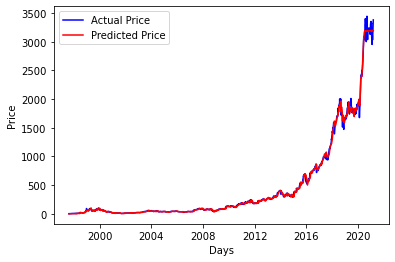

In [28]:
plot_graph(final_df)